In [1]:
import torch
import torchvision 
import os
from torch.utils import data
from PIL import Image
import torchvision.datasets as dset
import numpy as np

import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from tqdm.notebook import tqdm
import torchvision.models as models
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import matplotlib.pyplot as plt
import pickle
from torchsummary import summary

#vital params

 
model_name="ResNet152_stn2"

dataset_name="cifar10"

#hyperparameters
batch_size=20
num_classes=-1
learning_rate=0.001
input_size=784
image_size=(224,224)


if dataset_name == "tsrd":
    num_classes=58
elif dataset_name == "cifar10":
    num_classes=10
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("Model: "+model_name +" with {} classes".format(num_classes)+
      " running on: "+dataset_name)


Model: ResNet152_stn2 with 10 classes running on: cifar10


In [2]:
# load data through imagefolder
if dataset_name == "tsrd":
    main_transforms=transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.485, 0.456, 0.406] , std = [0.229, 0.224, 0.225]),

    ])

    train_dir = "../../dataset/data"
    head_train_set = dset.ImageFolder(train_dir,transform=main_transforms)
    train_set, valid_set = data.random_split(head_train_set, [5000, 998])
    train_set, test_set = data.random_split(train_set,[4000, 1000])


    train_dataloader=torch.utils.data.DataLoader(train_set,
                                                 batch_size=batch_size,
                                                 shuffle=True)

    val_dataloader=torch.utils.data.DataLoader(valid_set,
                                                 batch_size=batch_size,
                                                 shuffle=True)

    test_dataloader=torch.utils.data.DataLoader(test_set,
                                                 batch_size=1,
                                                 shuffle=True)
    print(head_train_set.class_to_idx)
elif dataset_name == "cifar10":
    
    main_transforms=transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.5, 0.5, 0.5] , std = [0.5, 0.5, 0.5]),

    ])

    bigtrain_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=main_transforms)
    train_set, valid_set = data.random_split(bigtrain_set, [40000, 10000])
    test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=main_transforms)


    train_dataloader = torch.utils.data.DataLoader(train_set, 
                                                   batch_size=batch_size, 
                                                   shuffle=True, num_workers=2)

    val_dataloader = torch.utils.data.DataLoader(valid_set, 
                                                   batch_size=batch_size, 
                                                   shuffle=True, num_workers=2)

    test_dataloader = torch.utils.data.DataLoader(test_set,
                                                  batch_size=batch_size,
                                                  shuffle=False, num_workers=2)




print("Dataset size: Train: {}, Valid: {}, Test: {}"
      .format(len(train_set),len(valid_set),len(test_set)))


print(train_set[0][0].shape)
print("Datasets loaded and prepared")

Files already downloaded and verified
Files already downloaded and verified
Dataset size: Train: 40000, Valid: 10000, Test: 10000
torch.Size([3, 224, 224])
Datasets loaded and prepared


In [3]:
class block(nn.Module):
    def __init__(
        self, in_channels, intermediate_channels, identity_downsample=None, stride=1
    ):
        super(block, self).__init__()
        self.expansion = 4
        self.conv1 = nn.Conv2d(
            in_channels, intermediate_channels, kernel_size=1, stride=1, padding=0, bias=False
        )
        self.bn1 = nn.BatchNorm2d(intermediate_channels)
        self.conv2 = nn.Conv2d(
            intermediate_channels,
            intermediate_channels,
            kernel_size=3,
            stride=stride,
            padding=1,
            bias=False
        )
        self.bn2 = nn.BatchNorm2d(intermediate_channels)
        self.conv3 = nn.Conv2d(
            intermediate_channels,
            intermediate_channels * self.expansion,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=False
        )
        self.bn3 = nn.BatchNorm2d(intermediate_channels * self.expansion)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample
        self.stride = stride

    def forward(self, x):
        identity = x.clone()
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        x = self.relu(x)
        return x


class ResNet(nn.Module):
    def __init__(self, block, layers, image_channels, num_classes):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Essentially the entire ResNet architecture are in these 4 lines below
        self.layer1 = self._make_layer(
            block, layers[0], intermediate_channels=64, stride=1
        )
        self.layer2 = self._make_layer(
            block, layers[1], intermediate_channels=128, stride=2
        )
        self.layer3 = self._make_layer(
            block, layers[2], intermediate_channels=256, stride=2
        )
        self.layer4 = self._make_layer(
            block, layers[3], intermediate_channels=512, stride=2
        )

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * 4, num_classes)

        self.localization = nn.Sequential(
            nn.Conv2d(3,4,kernel_size=3,stride = 2,padding=1),
            nn.BatchNorm2d(4),
            nn.ReLU(True),
            
            nn.Conv2d(4,8,kernel_size=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.Conv2d(8,8,kernel_size=3,stride=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.Conv2d(8,4,kernel_size=1),
            nn.BatchNorm2d(4),
            nn.ReLU(True),
            
            nn.Conv2d(4,8,kernel_size=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.Conv2d(8,8,kernel_size=3,stride=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.Conv2d(8,4,kernel_size=1),
            nn.BatchNorm2d(4),
            nn.ReLU(True),
            
            nn.Conv2d(4,8,kernel_size=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.Conv2d(8,8,kernel_size=3,stride=2,padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.Conv2d(8,4,kernel_size=1),
            nn.BatchNorm2d(4),
            nn.ReLU(True),
            
            nn.Conv2d(4,8,kernel_size=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.Conv2d(8,8,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.Conv2d(8,4,kernel_size=1),
            nn.BatchNorm2d(4),
            nn.ReLU(True),
            
            nn.Conv2d(4,8,kernel_size=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.Conv2d(8,8,kernel_size=3,stride=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.Conv2d(8,4,kernel_size=1),
            nn.BatchNorm2d(4),
            nn.ReLU(True),
            
            nn.Conv2d(4,10,kernel_size=1),
            nn.BatchNorm2d(10),
            nn.ReLU(True),
        )

        # Regressor for the 3 * 2 affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(27040, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )

        


        # Initialize the weights/bias with identity transformation
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

        
    # Spatial transformer network forward function
    def stn(self, x):

        xs = self.localization(x)

        xs = xs.view(-1, 10 * 52 * 52)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)
        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)
                
    def forward(self, x):
        self.stn(x)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)

        return x

    def _make_layer(self, block, num_residual_blocks, intermediate_channels, stride):
        identity_downsample = None
        layers = []

        # Either if we half the input space for ex, 56x56 -> 28x28 (stride=2), or channels changes
        # we need to adapt the Identity (skip connection) so it will be able to be added
        # to the layer that's ahead
        if stride != 1 or self.in_channels != intermediate_channels * 4:
            identity_downsample = nn.Sequential(
                nn.Conv2d(
                    self.in_channels,
                    intermediate_channels * 4,
                    kernel_size=1,
                    stride=stride,
                    bias=False
                ),
                nn.BatchNorm2d(intermediate_channels * 4),
            )

        layers.append(
            block(self.in_channels, intermediate_channels, identity_downsample, stride)
        )

        # The expansion size is always 4 for ResNet 50,101,152
        self.in_channels = intermediate_channels * 4

        # For example for first resnet layer: 256 will be mapped to 64 as intermediate layer,
        # then finally back to 256. Hence no identity downsample is needed, since stride = 1,
        # and also same amount of channels.
        for i in range(num_residual_blocks - 1):
            layers.append(block(self.in_channels, intermediate_channels))

        return nn.Sequential(*layers)



def ResNet50(img_channel=3, num_classes=num_classes):
    return ResNet(block, [3, 4, 6, 3], img_channel, num_classes)


def ResNet101(img_channel=3, num_classes=num_classes):
    return ResNet(block, [3, 4, 23, 3], img_channel, num_classes)


def ResNet152(img_channel=3, num_classes=num_classes):
    return ResNet(block, [3, 8, 36, 3], img_channel, num_classes)


def test():
    net = ResNet101(img_channel=3, num_classes=num_classes)
    y = net(torch.randn(4, 3, 224, 224)).to(device)
    print(y.size())


test()

C:\Users\2080Ti\Anaconda3\envs\pytorch\lib\site-packages\torch\nn\functional.py:4044: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
C:\Users\2080Ti\Anaconda3\envs\pytorch\lib\site-packages\torch\nn\functional.py:3982: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


torch.Size([4, 10])


In [4]:
model=ResNet152(img_channel=3, num_classes=num_classes).to(device)
from thop import profile
import colorama
from colorama import Fore,Style
#vital params
def getGFLOPS(test_model):
    model=test_model.to(device)
    input = torch.randn(1, 3, 224, 224).to(device)
    macs, params = profile(model, inputs=(input, ))

    print(Fore.BLUE + "The model requires: {:.4f} GFLOPS".format(macs/1000_000_000))
    print(Style.RESET_ALL)
    return macs
getGFLOPS(model)
#pretesting model for shape
x=torch.randn(batch_size,3,224,224)
x=x.to(device)
print(x.shape)
print(model(x).shape)
print("model shape ready")
print(summary(model, input_size=(3, 224, 224)))
#initailise network


#loss and optimizer
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(),lr=learning_rate)
print("model initialised")

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_bn() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.block'>. Treat it as zero Macs and zero Params.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[WARN] Cannot find rule for <class '__main__.ResNet'>. Treat it as zero Macs and zero Params.


C:\Users\2080Ti\Anaconda3\envs\pytorch\lib\site-packages\torch\_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  ..\aten\src\ATen\native\BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


The model requires: 11.5825 GFLOPS

torch.Size([20, 3, 224, 224])
torch.Size([20, 10])
model shape ready
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 112, 112]             112
       BatchNorm2d-2          [-1, 4, 112, 112]               8
              ReLU-3          [-1, 4, 112, 112]               0
            Conv2d-4          [-1, 8, 112, 112]              40
       BatchNorm2d-5          [-1, 8, 112, 112]              16
              ReLU-6          [-1, 8, 112, 112]               0
            Conv2d-7          [-1, 8, 110, 110]             584
       BatchNorm2d-8          [-1, 8, 110, 110]              16
              ReLU-9          [-1, 8, 110, 110]               0
           Conv2d-10          [-1, 4, 110, 110]              36
      BatchNorm2d-11          [-1, 4, 110, 110]               8
             ReLU-12          [-1, 4, 110, 110]               

In [5]:
# This is the testing part
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp
get_n_params(model)

def test(model, test_loader, istest= False, doprint=True):
    model.eval()
    test_loss = 0
    correct = 0
    TP=0
    TN=0
    FN=0
    FP=0
    test_loss = 0.0
    
    with torch.no_grad(): # disable gradient calculation for efficiency
        for data, target in tqdm(test_loader):
            # Prediction
            data=data.to(device=device)
            target=target.to(device=device)
            optimizer.zero_grad()
            
            output = model(data)
            loss=criterion(output,target)
            
            # Compute loss & accuracy
            test_loss+=loss.item()*data.size(0)

            
            #test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item() # how many predictions in this batch are correct
            
            #print("pred={} , target={} , judge={}".format(pred.item(),target.item(),pred.eq(target.view_as(pred)).sum().item()))

            
    #test_loss /= len(test_loader.dataset)

        
    # Log testing info
    if istest and doprint:
        
        print('Loss: {}   Accuracy: {}/{} ({:.3f}%)'.format(test_loss,
        correct, len(test_loader.dataset),
        100.000 * correct / len(test_loader.dataset)))
        print("Total parameters: {}".format(get_n_params(model)))
    elif doprint:
        print('Accuracy: {}/{} ({:.3f}%)'.format(
        correct, len(test_loader.dataset),
        100.000 * correct / len(test_loader.dataset)))
    return 100.000 * correct / len(test_loader.dataset)
        

print("test defined")

def testshouldearlystop(acclist,minepoch,epochwindow,accwindow):
    runlen=len(acclist)
    if(runlen<minepoch):
        return False
    elif(acclist[-1]>acclist[-2]):
        return False
    
    watchwindow=acclist[-epochwindow:]
    shouldjump=True
    sum=0
    for i in watchwindow:
        sum+=i
    avg = sum/epochwindow
    for i in watchwindow:
        if abs(i-avg)>(accwindow):
            shouldjump=False
    return shouldjump
print("early stop defined")

test defined
early stop defined


In [6]:
now=datetime.now()
dt_string = now.strftime("%Y%m%d%H%M%S")

tensorboard_string="runs/"+"/"+model_name+dt_string
grandstore_string="grandstore/"+dataset_name+"_"+model_name+dt_string+".pkl"
print("tensorboard_string:")
print(tensorboard_string)
print("grandstore_string")
print(grandstore_string)


writer = SummaryWriter(tensorboard_string)


tensorboard_string:
runs//ResNet152_stn220211218201010
grandstore_string
grandstore/cifar10_ResNet152_stn220211218201010.pkl


In [7]:
#This is the training part

# Grand_store={
#     'total_epoch_run':-1
#     'topmodels':-1
#     'lastmodel':-1
#     'acclog':[]
#     'maxacc':-1
#     'minacc':101
# }
# train_epoch={
#     "numofepoch":-1
#     "accuracy":-1
#     "model_state":model.state_dict(),
#     "optim_state":optimizer.state_dict(),
#     "totaltrain_loss":totaltrain_loss,
#     "totalvalid_loss":totalvalid_loss
# }

def training(max_epoch=120, top_accuracy_track=3, grandstore={},
             minepoch=30,epochwindow=10,accwindow=0.35):

    grandstore['total_epoch_run']=0
    grandstore['topmodels']=[]
    grandstore['acclog']=[]
    grandstore['maxacc']=-1
    grandstore['minacc']=101
    
    for epoch in range(0,max_epoch):
        
        grandstore['total_epoch_run']=epoch+1
        
        train_epoch={
        "numofepoch":grandstore['total_epoch_run']
        }
    
        train_loss=0.0
        valid_loss=0.0
        print("Running epoch: {}".format(epoch+1))

        model.train()
        totaltrain_loss=0
        
        #this is the training part
        for data,target in tqdm(train_dataloader):
            data=data.to(device=device)
            target=target.to(device=device)
            output = model(data)
            loss = criterion(output, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()*data.size(0)
            totaltrain_loss += train_loss

        #this is the validation part
        model.eval()
        totalvalid_loss=0;
        correct = 0
        for data,target in tqdm(val_dataloader):
            data=data.to(device=device)
            target=target.to(device=device)
            output=model(data)
            loss=criterion(output,target)
            valid_loss=loss.item()*data.size(0)
            #train_loss = train_loss/len(train_dataloader.dataset)
            #valid_loss = valid_loss/len(val_dataloader.dataset)
            totalvalid_loss+=valid_loss
            
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item() # how many predictions in t
        

        training_accuracy=100. * correct / len(val_dataloader.dataset)
        train_epoch["accuracy"]=training_accuracy
        train_epoch["totaltrain_loss"]=totaltrain_loss
        train_epoch["totalvalid_loss"]=totalvalid_loss
        
        #writings to the GrandStore
        
        grandstore['acclog'].append(training_accuracy)
        
        if training_accuracy < grandstore['minacc']:
            grandstore['minacc'] = training_accuracy
            
        if training_accuracy > grandstore['maxacc']:
            grandstore['maxacc'] = training_accuracy
        

        if epoch < top_accuracy_track:
            thisepochtestresult=test(model,test_dataloader,istest = True,doprint=False)
            grandstore['topmodels'].append((training_accuracy,thisepochtestresult,epoch+1,train_epoch))
            #if error print this
            grandstore['topmodels'].sort()

        elif training_accuracy > grandstore['topmodels'][0][0]:
            thisepochtestresult=test(model,test_dataloader,istest = True,doprint=False)
            grandstore['topmodels'][0]=(training_accuracy,thisepochtestresult,epoch+1,train_epoch)
            #if error print this
            grandstore['topmodels'].sort()

        if epoch == (max_epoch-1):
            thisepochtestresult=test(model,test_dataloader,istest = True,doprint=False)
            grandstore['lastmodel']=(training_accuracy,thisepochtestresult,epoch+1,train_epoch)
                     
        writer.add_scalar('Training Loss',totaltrain_loss,global_step = epoch)
        writer.add_scalar('Valid Loss',totalvalid_loss,global_step = epoch)
        writer.add_scalar('Accuracy',training_accuracy,global_step = epoch)
        
        print('Accuracy: {:.3f}'.format(training_accuracy))
        print('Training Loss: {:.4f} \tValidation Loss: {:.4f}\n'.format(totaltrain_loss, totalvalid_loss))
        
        #early stopping criteria
        if(testshouldearlystop(acclist=grandstore['acclog'],
                               minepoch = minepoch,
                               epochwindow = epochwindow,
                               accwindow = accwindow)):
            print("early stop occured!!")
            thisepochtestresult=test(model,test_dataloader,istest = True,doprint=False)
            grandstore['lastmodel']=(training_accuracy,thisepochtestresult,epoch+1,train_epoch)
            return grandstore
    
    return grandstore
        


In [8]:
TOP_ACCURACY_TRACK = 15
# max_epoch=120, top_accuracy_track=3, grandstore={},
# minepoch=30,epochwindow=10,accwindow=0.35

Grandstore=training(max_epoch=400,
                    minepoch=300,
                    top_accuracy_track=TOP_ACCURACY_TRACK,
                    epochwindow=10,
                    accwindow=0.25                  
                   )

Running epoch: 1


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 39.590
Training Loss: 78804659.9540 	Validation Loss: 17209.9428

Running epoch: 2


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 45.290
Training Loss: 59548690.9526 	Validation Loss: 16153.7917

Running epoch: 3


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 63.160
Training Loss: 46392670.1288 	Validation Loss: 10219.5716

Running epoch: 4


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 71.670
Training Loss: 37223075.8909 	Validation Loss: 8261.7710

Running epoch: 5


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 73.490
Training Loss: 30529007.2182 	Validation Loss: 7762.6553

Running epoch: 6


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 77.170
Training Loss: 26155247.5362 	Validation Loss: 6736.6457

Running epoch: 7


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 81.330
Training Loss: 22465047.9515 	Validation Loss: 5420.6605

Running epoch: 8


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 81.350
Training Loss: 18944788.3631 	Validation Loss: 5496.1859

Running epoch: 9


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 81.400
Training Loss: 15608296.1174 	Validation Loss: 5497.3494

Running epoch: 10


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 82.480
Training Loss: 12935234.9527 	Validation Loss: 5305.3502

Running epoch: 11


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 83.620
Training Loss: 10143129.5412 	Validation Loss: 5120.5759

Running epoch: 12


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 83.580
Training Loss: 7901673.7314 	Validation Loss: 5157.8312

Running epoch: 13


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 83.310
Training Loss: 6239087.7905 	Validation Loss: 5702.3699

Running epoch: 14


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 82.880
Training Loss: 4925341.0432 	Validation Loss: 6404.4257

Running epoch: 15


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 83.500
Training Loss: 4147005.9757 	Validation Loss: 6264.3003

Running epoch: 16


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.060
Training Loss: 3718263.3301 	Validation Loss: 5709.6118

Running epoch: 17


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 83.290
Training Loss: 3068525.4503 	Validation Loss: 6777.3100

Running epoch: 18


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 83.820
Training Loss: 2963144.9808 	Validation Loss: 6468.1103

Running epoch: 19


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 83.300
Training Loss: 2739725.8798 	Validation Loss: 7060.5780

Running epoch: 20


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 81.100
Training Loss: 2364969.2353 	Validation Loss: 8597.0465

Running epoch: 21


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.100
Training Loss: 2266204.7478 	Validation Loss: 6269.6256

Running epoch: 22


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 84.390
Training Loss: 2071021.3271 	Validation Loss: 7074.8586

Running epoch: 23


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 84.000
Training Loss: 1840318.0950 	Validation Loss: 7517.0616

Running epoch: 24


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 83.730
Training Loss: 1792872.9369 	Validation Loss: 7487.9485

Running epoch: 25


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 84.710
Training Loss: 1742493.8987 	Validation Loss: 6887.2595

Running epoch: 26


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 84.600
Training Loss: 1564606.5880 	Validation Loss: 7124.6537

Running epoch: 27


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 84.470
Training Loss: 1605227.9155 	Validation Loss: 7260.3312

Running epoch: 28


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 84.480
Training Loss: 1481764.5723 	Validation Loss: 7365.9594

Running epoch: 29


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 84.500
Training Loss: 1347042.6157 	Validation Loss: 7440.6809

Running epoch: 30


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 84.620
Training Loss: 1213028.7534 	Validation Loss: 8038.0874

Running epoch: 31


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 84.160
Training Loss: 1332875.9073 	Validation Loss: 8243.4271

Running epoch: 32


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 84.160
Training Loss: 1360225.7709 	Validation Loss: 8500.9526

Running epoch: 33


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 84.980
Training Loss: 1208735.7073 	Validation Loss: 7677.4863

Running epoch: 34


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 84.960
Training Loss: 1273100.1422 	Validation Loss: 7665.3284

Running epoch: 35


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.460
Training Loss: 1148772.0077 	Validation Loss: 7850.4598

Running epoch: 36


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 84.890
Training Loss: 1109796.0334 	Validation Loss: 7605.7396

Running epoch: 37


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 84.610
Training Loss: 1273209.6112 	Validation Loss: 7882.6198

Running epoch: 38


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.120
Training Loss: 1015057.8033 	Validation Loss: 7160.4595

Running epoch: 39


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.570
Training Loss: 845356.3353 	Validation Loss: 7547.6230

Running epoch: 40


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 84.530
Training Loss: 831212.0507 	Validation Loss: 7774.2424

Running epoch: 41


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.140
Training Loss: 794901.1897 	Validation Loss: 7473.3724

Running epoch: 42


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.440
Training Loss: 866680.6917 	Validation Loss: 7037.8358

Running epoch: 43


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.170
Training Loss: 791980.7021 	Validation Loss: 7559.6524

Running epoch: 44


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 84.060
Training Loss: 810924.0480 	Validation Loss: 8617.3792

Running epoch: 45


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.350
Training Loss: 793077.4373 	Validation Loss: 8072.1040

Running epoch: 46


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 84.260
Training Loss: 776641.6177 	Validation Loss: 8811.6554

Running epoch: 47


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.120
Training Loss: 764181.4998 	Validation Loss: 7867.2176

Running epoch: 48


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 84.990
Training Loss: 651935.8456 	Validation Loss: 8224.2103

Running epoch: 49


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 84.220
Training Loss: 927257.6291 	Validation Loss: 8162.5980

Running epoch: 50


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 83.600
Training Loss: 762129.1483 	Validation Loss: 9145.7497

Running epoch: 51


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.680
Training Loss: 810779.8251 	Validation Loss: 7990.0038

Running epoch: 52


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.370
Training Loss: 724562.7969 	Validation Loss: 8366.0017

Running epoch: 53


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 84.470
Training Loss: 697605.7007 	Validation Loss: 8457.0682

Running epoch: 54


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.150
Training Loss: 613494.1591 	Validation Loss: 8367.6353

Running epoch: 55


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.600
Training Loss: 703632.1619 	Validation Loss: 8393.3387

Running epoch: 56


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 82.630
Training Loss: 684765.0871 	Validation Loss: 10735.0418

Running epoch: 57


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 84.680
Training Loss: 632343.1848 	Validation Loss: 8314.5820

Running epoch: 58


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.040
Training Loss: 571242.4044 	Validation Loss: 8277.6275

Running epoch: 59


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.290
Training Loss: 582548.0533 	Validation Loss: 8094.1777

Running epoch: 60


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 84.210
Training Loss: 683236.3841 	Validation Loss: 9447.1578

Running epoch: 61


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.250
Training Loss: 517299.9770 	Validation Loss: 8530.5475

Running epoch: 62


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 84.200
Training Loss: 643583.5154 	Validation Loss: 9023.2557

Running epoch: 63


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.420
Training Loss: 563925.0205 	Validation Loss: 8713.9020

Running epoch: 64


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.250
Training Loss: 545327.8628 	Validation Loss: 8753.9286

Running epoch: 65


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 84.520
Training Loss: 451999.5039 	Validation Loss: 9636.4448

Running epoch: 66


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 84.650
Training Loss: 539185.2342 	Validation Loss: 9199.1657

Running epoch: 67


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 84.370
Training Loss: 674011.0991 	Validation Loss: 9451.1120

Running epoch: 68


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.500
Training Loss: 501822.8518 	Validation Loss: 8464.4793

Running epoch: 69


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.420
Training Loss: 610287.6531 	Validation Loss: 8531.5433

Running epoch: 70


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.050
Training Loss: 461001.9178 	Validation Loss: 9171.3127

Running epoch: 71


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.100
Training Loss: 506373.5495 	Validation Loss: 8665.4339

Running epoch: 72


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 84.920
Training Loss: 491731.9485 	Validation Loss: 8848.9788

Running epoch: 73


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.510
Training Loss: 496016.3143 	Validation Loss: 8258.1695

Running epoch: 74


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 84.480
Training Loss: 422170.8031 	Validation Loss: 9200.4777

Running epoch: 75


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.910
Training Loss: 413134.8491 	Validation Loss: 8635.8081

Running epoch: 76


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.320
Training Loss: 499833.7141 	Validation Loss: 8351.5027

Running epoch: 77


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.660
Training Loss: 369340.5568 	Validation Loss: 8825.5391

Running epoch: 78


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 84.220
Training Loss: 573632.6844 	Validation Loss: 9203.8584

Running epoch: 79


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.360
Training Loss: 459557.2044 	Validation Loss: 8634.0445

Running epoch: 80


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 83.860
Training Loss: 453550.9885 	Validation Loss: 10948.7127

Running epoch: 81


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.360
Training Loss: 523143.2515 	Validation Loss: 9263.2956

Running epoch: 82


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.050
Training Loss: 361051.2568 	Validation Loss: 9545.1644

Running epoch: 83


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.220
Training Loss: 598314.8799 	Validation Loss: 9250.5033

Running epoch: 84


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.340
Training Loss: 428420.3534 	Validation Loss: 8962.9294

Running epoch: 85


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.180
Training Loss: 498649.1885 	Validation Loss: 9073.4849

Running epoch: 86


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.510
Training Loss: 299671.4468 	Validation Loss: 9627.0150

Running epoch: 87


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.070
Training Loss: 486479.8492 	Validation Loss: 9478.0957

Running epoch: 88


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 84.910
Training Loss: 348995.0754 	Validation Loss: 9078.5336

Running epoch: 89


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.730
Training Loss: 433069.8810 	Validation Loss: 8842.3954

Running epoch: 90


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.500
Training Loss: 388948.0262 	Validation Loss: 8915.5356

Running epoch: 91


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.070
Training Loss: 411100.4913 	Validation Loss: 9957.7784

Running epoch: 92


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.760
Training Loss: 356171.6037 	Validation Loss: 8946.5987

Running epoch: 93


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 84.800
Training Loss: 269965.1927 	Validation Loss: 9938.1725

Running epoch: 94


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.310
Training Loss: 473118.2328 	Validation Loss: 8896.3222

Running epoch: 95


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.620
Training Loss: 434215.3925 	Validation Loss: 8519.6206

Running epoch: 96


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.010
Training Loss: 286959.7732 	Validation Loss: 8552.0783

Running epoch: 97


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.570
Training Loss: 297470.8188 	Validation Loss: 9300.0949

Running epoch: 98


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.020
Training Loss: 373771.7165 	Validation Loss: 8684.9504

Running epoch: 99


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.370
Training Loss: 377495.4349 	Validation Loss: 9187.4119

Running epoch: 100


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.980
Training Loss: 423380.0928 	Validation Loss: 9217.4950

Running epoch: 101


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.240
Training Loss: 234175.5002 	Validation Loss: 9662.2260

Running epoch: 102


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 84.960
Training Loss: 344646.7442 	Validation Loss: 9235.8334

Running epoch: 103


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.570
Training Loss: 364724.2074 	Validation Loss: 9618.1637

Running epoch: 104


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.650
Training Loss: 406031.3476 	Validation Loss: 8892.3353

Running epoch: 105


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.340
Training Loss: 371084.3055 	Validation Loss: 8653.2665

Running epoch: 106


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.280
Training Loss: 228330.9358 	Validation Loss: 10027.0031

Running epoch: 107


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.500
Training Loss: 417596.4721 	Validation Loss: 9844.4705

Running epoch: 108


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.670
Training Loss: 263236.6410 	Validation Loss: 9041.9588

Running epoch: 109


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 84.970
Training Loss: 333134.6757 	Validation Loss: 9434.0226

Running epoch: 110


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 84.630
Training Loss: 297295.0396 	Validation Loss: 10358.6309

Running epoch: 111


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.250
Training Loss: 376603.5441 	Validation Loss: 9301.0774

Running epoch: 112


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 84.990
Training Loss: 276062.3465 	Validation Loss: 9399.6884

Running epoch: 113


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.570
Training Loss: 324936.3157 	Validation Loss: 9441.3219

Running epoch: 114


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.220
Training Loss: 207872.9171 	Validation Loss: 9588.6480

Running epoch: 115


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.300
Training Loss: 270433.1585 	Validation Loss: 10476.0791

Running epoch: 116


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.380
Training Loss: 329163.8366 	Validation Loss: 9428.5457

Running epoch: 117


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 84.940
Training Loss: 315880.6192 	Validation Loss: 9961.4013

Running epoch: 118


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 84.450
Training Loss: 293859.3516 	Validation Loss: 10836.2001

Running epoch: 119


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.550
Training Loss: 278847.4998 	Validation Loss: 9567.7178

Running epoch: 120


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 84.740
Training Loss: 241610.9456 	Validation Loss: 10386.6422

Running epoch: 121


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 84.700
Training Loss: 329280.6939 	Validation Loss: 11181.4078

Running epoch: 122


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.050
Training Loss: 349916.1425 	Validation Loss: 9517.3334

Running epoch: 123


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.150
Training Loss: 220851.0184 	Validation Loss: 9752.4419

Running epoch: 124


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.450
Training Loss: 344179.7304 	Validation Loss: 9824.7473

Running epoch: 125


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.770
Training Loss: 261497.0111 	Validation Loss: 9955.1315

Running epoch: 126


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 84.330
Training Loss: 321369.5404 	Validation Loss: 11720.8174

Running epoch: 127


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 84.670
Training Loss: 286981.6923 	Validation Loss: 10864.9392

Running epoch: 128


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 84.830
Training Loss: 324806.2677 	Validation Loss: 9878.8955

Running epoch: 129


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 83.680
Training Loss: 241243.4197 	Validation Loss: 11490.4799

Running epoch: 130


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.940
Training Loss: 363573.9354 	Validation Loss: 9633.0415

Running epoch: 131


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.320
Training Loss: 262709.7058 	Validation Loss: 10603.0671

Running epoch: 132


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.930
Training Loss: 308688.8515 	Validation Loss: 9990.6002

Running epoch: 133


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.940
Training Loss: 305980.2720 	Validation Loss: 9675.4010

Running epoch: 134


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.810
Training Loss: 227914.1015 	Validation Loss: 10337.6872

Running epoch: 135


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 84.690
Training Loss: 293706.2101 	Validation Loss: 11850.9598

Running epoch: 136


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 84.590
Training Loss: 278596.7337 	Validation Loss: 10458.1298

Running epoch: 137


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 84.020
Training Loss: 272005.6056 	Validation Loss: 11876.3236

Running epoch: 138


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.990
Training Loss: 302545.1561 	Validation Loss: 10306.0409

Running epoch: 139


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.770
Training Loss: 369081.0572 	Validation Loss: 10299.8723

Running epoch: 140


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.680
Training Loss: 354935.5186 	Validation Loss: 10038.1148

Running epoch: 141


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 84.830
Training Loss: 227471.3746 	Validation Loss: 10796.2657

Running epoch: 142


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.250
Training Loss: 297190.5993 	Validation Loss: 10576.9156

Running epoch: 143


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.360
Training Loss: 236632.7432 	Validation Loss: 9764.8704

Running epoch: 144


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.520
Training Loss: 233959.9704 	Validation Loss: 10061.6069

Running epoch: 145


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.540
Training Loss: 285735.0393 	Validation Loss: 9605.7378

Running epoch: 146


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.880
Training Loss: 315951.4038 	Validation Loss: 9400.4557

Running epoch: 147


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.600
Training Loss: 195384.4666 	Validation Loss: 9868.2699

Running epoch: 148


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.720
Training Loss: 242539.7865 	Validation Loss: 10382.2764

Running epoch: 149


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.450
Training Loss: 301476.5285 	Validation Loss: 10486.5266

Running epoch: 150


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.040
Training Loss: 249391.3498 	Validation Loss: 9420.3188

Running epoch: 151


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.790
Training Loss: 218786.9950 	Validation Loss: 10512.8280

Running epoch: 152


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.520
Training Loss: 239705.3626 	Validation Loss: 10881.0561

Running epoch: 153


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.290
Training Loss: 164088.8270 	Validation Loss: 10084.1541

Running epoch: 154


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.100
Training Loss: 232448.7713 	Validation Loss: 9359.7734

Running epoch: 155


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.400
Training Loss: 184585.0821 	Validation Loss: 10371.4411

Running epoch: 156


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.060
Training Loss: 219895.2909 	Validation Loss: 9432.8361

Running epoch: 157


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.810
Training Loss: 269740.9916 	Validation Loss: 10068.6574

Running epoch: 158


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 84.710
Training Loss: 214917.0435 	Validation Loss: 11459.2538

Running epoch: 159


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.000
Training Loss: 170700.6030 	Validation Loss: 10046.4048

Running epoch: 160


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 84.970
Training Loss: 271247.9610 	Validation Loss: 10387.5914

Running epoch: 161


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.620
Training Loss: 238004.2252 	Validation Loss: 9465.9980

Running epoch: 162


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.360
Training Loss: 259169.9239 	Validation Loss: 10087.8467

Running epoch: 163


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 83.810
Training Loss: 180103.5897 	Validation Loss: 12338.9614

Running epoch: 164


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.620
Training Loss: 264237.7808 	Validation Loss: 10032.6472

Running epoch: 165


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.070
Training Loss: 226188.5604 	Validation Loss: 9981.5079

Running epoch: 166


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.920
Training Loss: 205619.1141 	Validation Loss: 9885.9969

Running epoch: 167


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.900
Training Loss: 220637.9916 	Validation Loss: 10242.3540

Running epoch: 168


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.940
Training Loss: 278284.1261 	Validation Loss: 10226.9736

Running epoch: 169


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.380
Training Loss: 186767.4679 	Validation Loss: 10470.3457

Running epoch: 170


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.420
Training Loss: 209536.2650 	Validation Loss: 10628.7609

Running epoch: 171


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.410
Training Loss: 214682.2580 	Validation Loss: 10471.9969

Running epoch: 172


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.810
Training Loss: 381499.1869 	Validation Loss: 10302.2490

Running epoch: 173


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.650
Training Loss: 193156.0532 	Validation Loss: 10171.5017

Running epoch: 174


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.310
Training Loss: 279911.5430 	Validation Loss: 9913.8528

Running epoch: 175


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.860
Training Loss: 150877.9649 	Validation Loss: 10367.7393

Running epoch: 176


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.070
Training Loss: 257131.7244 	Validation Loss: 11117.5541

Running epoch: 177


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 84.650
Training Loss: 262034.8283 	Validation Loss: 10969.5704

Running epoch: 178


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.080
Training Loss: 191020.7917 	Validation Loss: 9853.5464

Running epoch: 179


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.570
Training Loss: 184406.2574 	Validation Loss: 9876.0614

Running epoch: 180


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.110
Training Loss: 179870.6949 	Validation Loss: 11374.6998

Running epoch: 181


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.850
Training Loss: 204812.2787 	Validation Loss: 10881.5317

Running epoch: 182


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.170
Training Loss: 212619.9184 	Validation Loss: 10482.6875

Running epoch: 183


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.280
Training Loss: 168492.9321 	Validation Loss: 10584.1995

Running epoch: 184


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.940
Training Loss: 278477.3020 	Validation Loss: 10366.6133

Running epoch: 185


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.190
Training Loss: 188005.2888 	Validation Loss: 11105.9681

Running epoch: 186


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.760
Training Loss: 142832.2283 	Validation Loss: 11622.2638

Running epoch: 187


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.170
Training Loss: 216597.3015 	Validation Loss: 12450.1247

Running epoch: 188


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.250
Training Loss: 199068.3993 	Validation Loss: 11176.2680

Running epoch: 189


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.050
Training Loss: 182231.8065 	Validation Loss: 10295.3662

Running epoch: 190


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 84.770
Training Loss: 179998.5651 	Validation Loss: 12898.7683

Running epoch: 191


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.870
Training Loss: 380158.9828 	Validation Loss: 11010.1569

Running epoch: 192


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.700
Training Loss: 157505.6614 	Validation Loss: 11338.8094

Running epoch: 193


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.600
Training Loss: 237018.1276 	Validation Loss: 10943.7095

Running epoch: 194


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.520
Training Loss: 175239.0628 	Validation Loss: 10418.5530

Running epoch: 195


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.870
Training Loss: 178541.3504 	Validation Loss: 11220.6333

Running epoch: 196


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.090
Training Loss: 195296.7479 	Validation Loss: 10766.2564

Running epoch: 197


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.630
Training Loss: 248642.9253 	Validation Loss: 10628.9436

Running epoch: 198


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.430
Training Loss: 119622.3624 	Validation Loss: 11137.3568

Running epoch: 199


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.840
Training Loss: 280069.0815 	Validation Loss: 10454.9673

Running epoch: 200


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.830
Training Loss: 167126.3767 	Validation Loss: 10848.8979

Running epoch: 201


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.620
Training Loss: 149482.2797 	Validation Loss: 11567.0479

Running epoch: 202


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.010
Training Loss: 256105.7641 	Validation Loss: 10173.6894

Running epoch: 203


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.690
Training Loss: 160176.8569 	Validation Loss: 11280.1511

Running epoch: 204


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.630
Training Loss: 173666.1202 	Validation Loss: 11258.8994

Running epoch: 205


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.420
Training Loss: 146443.9240 	Validation Loss: 10843.1900

Running epoch: 206


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.960
Training Loss: 164549.5474 	Validation Loss: 10500.2862

Running epoch: 207


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.590
Training Loss: 182695.1214 	Validation Loss: 11137.6707

Running epoch: 208


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.060
Training Loss: 215667.5560 	Validation Loss: 10624.5844

Running epoch: 209


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 84.550
Training Loss: 137770.6829 	Validation Loss: 12236.3379

Running epoch: 210


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.320
Training Loss: 201287.1441 	Validation Loss: 12447.1392

Running epoch: 211


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.780
Training Loss: 240845.1337 	Validation Loss: 10997.6263

Running epoch: 212


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.770
Training Loss: 149868.5212 	Validation Loss: 11190.3128

Running epoch: 213


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 84.630
Training Loss: 147336.5137 	Validation Loss: 12541.1273

Running epoch: 214


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.850
Training Loss: 234236.2707 	Validation Loss: 10628.8554

Running epoch: 215


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.770
Training Loss: 183034.6904 	Validation Loss: 11867.9787

Running epoch: 216


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.850
Training Loss: 148066.3421 	Validation Loss: 11900.5247

Running epoch: 217


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.220
Training Loss: 302556.2710 	Validation Loss: 11625.3676

Running epoch: 218


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.480
Training Loss: 152802.5559 	Validation Loss: 11714.3453

Running epoch: 219


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.830
Training Loss: 166447.7609 	Validation Loss: 10897.6585

Running epoch: 220


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.720
Training Loss: 140602.1728 	Validation Loss: 11923.7334

Running epoch: 221


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.520
Training Loss: 236813.0776 	Validation Loss: 11911.3515

Running epoch: 222


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.410
Training Loss: 189435.5819 	Validation Loss: 10949.9384

Running epoch: 223


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.810
Training Loss: 114461.2670 	Validation Loss: 11201.2845

Running epoch: 224


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.680
Training Loss: 237290.7194 	Validation Loss: 11009.3300

Running epoch: 225


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.070
Training Loss: 189932.2265 	Validation Loss: 12230.7022

Running epoch: 226


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.730
Training Loss: 264942.5358 	Validation Loss: 11773.6299

Running epoch: 227


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.390
Training Loss: 147218.1176 	Validation Loss: 11231.6685

Running epoch: 228


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.120
Training Loss: 216856.4228 	Validation Loss: 10675.4591

Running epoch: 229


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.360
Training Loss: 143905.7642 	Validation Loss: 10715.6478

Running epoch: 230


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.460
Training Loss: 133701.4473 	Validation Loss: 11294.2916

Running epoch: 231


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.050
Training Loss: 178932.4142 	Validation Loss: 11454.8033

Running epoch: 232


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.790
Training Loss: 194899.5876 	Validation Loss: 12114.8984

Running epoch: 233


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.490
Training Loss: 238966.7147 	Validation Loss: 12188.4559

Running epoch: 234


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.210
Training Loss: 132651.3840 	Validation Loss: 10994.9126

Running epoch: 235


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.060
Training Loss: 211280.4150 	Validation Loss: 11143.1672

Running epoch: 236


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.500
Training Loss: 153750.7963 	Validation Loss: 10958.6045

Running epoch: 237


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.980
Training Loss: 178298.1576 	Validation Loss: 11736.9722

Running epoch: 238


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.540
Training Loss: 171880.1249 	Validation Loss: 11383.3936

Running epoch: 239


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.400
Training Loss: 156145.7103 	Validation Loss: 12774.8741

Running epoch: 240


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 84.700
Training Loss: 179924.4814 	Validation Loss: 12791.4767

Running epoch: 241


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.720
Training Loss: 291622.0857 	Validation Loss: 11824.8405

Running epoch: 242


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.570
Training Loss: 184597.6274 	Validation Loss: 11485.7474

Running epoch: 243


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.780
Training Loss: 254652.7276 	Validation Loss: 10998.4562

Running epoch: 244


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.640
Training Loss: 92093.0662 	Validation Loss: 11937.0983

Running epoch: 245


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.810
Training Loss: 111898.2089 	Validation Loss: 11075.4521

Running epoch: 246


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.760
Training Loss: 151872.7321 	Validation Loss: 11706.7165

Running epoch: 247


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.450
Training Loss: 165868.6228 	Validation Loss: 12528.0206

Running epoch: 248


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.020
Training Loss: 207899.6569 	Validation Loss: 11516.6011

Running epoch: 249


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.390
Training Loss: 203063.2282 	Validation Loss: 12778.7380

Running epoch: 250


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.240
Training Loss: 135104.8405 	Validation Loss: 11977.6514

Running epoch: 251


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.250
Training Loss: 208391.6768 	Validation Loss: 12476.2568

Running epoch: 252


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 84.840
Training Loss: 88539.8259 	Validation Loss: 13109.1579

Running epoch: 253


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.200
Training Loss: 200780.0685 	Validation Loss: 12234.1673

Running epoch: 254


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.520
Training Loss: 176087.9028 	Validation Loss: 11916.3340

Running epoch: 255


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.950
Training Loss: 258420.6303 	Validation Loss: 11758.0283

Running epoch: 256


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.210
Training Loss: 94021.8476 	Validation Loss: 12044.1112

Running epoch: 257


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 84.730
Training Loss: 154115.4096 	Validation Loss: 12931.5894

Running epoch: 258


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.820
Training Loss: 182040.0238 	Validation Loss: 11704.0044

Running epoch: 259


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.020
Training Loss: 193404.3510 	Validation Loss: 11948.6332

Running epoch: 260


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.060
Training Loss: 221095.7367 	Validation Loss: 13352.0044

Running epoch: 261


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 84.930
Training Loss: 141712.9086 	Validation Loss: 14294.0481

Running epoch: 262


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.030
Training Loss: 178635.1632 	Validation Loss: 12179.4206

Running epoch: 263


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.320
Training Loss: 180182.5232 	Validation Loss: 13319.4234

Running epoch: 264


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.600
Training Loss: 196005.3113 	Validation Loss: 11582.7585

Running epoch: 265


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.760
Training Loss: 148647.0594 	Validation Loss: 11408.8665

Running epoch: 266


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.810
Training Loss: 105261.8770 	Validation Loss: 12194.8475

Running epoch: 267


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.330
Training Loss: 132996.6791 	Validation Loss: 12753.2122

Running epoch: 268


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.030
Training Loss: 101468.9741 	Validation Loss: 13178.3245

Running epoch: 269


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.390
Training Loss: 215640.1719 	Validation Loss: 12984.1273

Running epoch: 270


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.210
Training Loss: 169134.0080 	Validation Loss: 12257.3789

Running epoch: 271


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.170
Training Loss: 158507.7350 	Validation Loss: 12487.6107

Running epoch: 272


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.240
Training Loss: 199846.8379 	Validation Loss: 11678.6884

Running epoch: 273


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.280
Training Loss: 108682.3852 	Validation Loss: 12241.7760

Running epoch: 274


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.470
Training Loss: 186623.4029 	Validation Loss: 12409.5125

Running epoch: 275


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.070
Training Loss: 193965.2977 	Validation Loss: 12123.7746

Running epoch: 276


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.260
Training Loss: 162393.8466 	Validation Loss: 12551.0813

Running epoch: 277


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.710
Training Loss: 100848.5160 	Validation Loss: 12146.6316

Running epoch: 278


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.410
Training Loss: 250276.7269 	Validation Loss: 11780.2810

Running epoch: 279


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.040
Training Loss: 159371.8803 	Validation Loss: 12270.9287

Running epoch: 280


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.780
Training Loss: 215694.3231 	Validation Loss: 12177.9947

Running epoch: 281


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.420
Training Loss: 53365.1738 	Validation Loss: 12619.9702

Running epoch: 282


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.560
Training Loss: 193713.1411 	Validation Loss: 13169.0569

Running epoch: 283


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.350
Training Loss: 112460.0255 	Validation Loss: 12679.1189

Running epoch: 284


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.770
Training Loss: 156944.2696 	Validation Loss: 12591.1456

Running epoch: 285


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.750
Training Loss: 124460.6259 	Validation Loss: 12749.5294

Running epoch: 286


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.860
Training Loss: 220599.2616 	Validation Loss: 12473.7527

Running epoch: 287


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.470
Training Loss: 223671.5376 	Validation Loss: 11670.7955

Running epoch: 288


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.370
Training Loss: 137529.3464 	Validation Loss: 12189.7496

Running epoch: 289


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.110
Training Loss: 214936.3014 	Validation Loss: 11862.5375

Running epoch: 290


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.400
Training Loss: 110851.9183 	Validation Loss: 13148.7337

Running epoch: 291


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.190
Training Loss: 135389.5337 	Validation Loss: 12957.1821

Running epoch: 292


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.430
Training Loss: 159642.0642 	Validation Loss: 11947.7226

Running epoch: 293


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.080
Training Loss: 102575.0989 	Validation Loss: 11861.6586

Running epoch: 294


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.930
Training Loss: 236624.5021 	Validation Loss: 11692.2142

Running epoch: 295


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.560
Training Loss: 124570.8222 	Validation Loss: 11914.4234

Running epoch: 296


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.040
Training Loss: 185147.0004 	Validation Loss: 12731.0790

Running epoch: 297


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.150
Training Loss: 187259.8103 	Validation Loss: 12256.3094

Running epoch: 298


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.980
Training Loss: 128642.0545 	Validation Loss: 11994.5843

Running epoch: 299


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.110
Training Loss: 146069.8421 	Validation Loss: 12543.9321

Running epoch: 300


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.400
Training Loss: 170439.4152 	Validation Loss: 12046.5904

Running epoch: 301


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.340
Training Loss: 223043.7214 	Validation Loss: 12538.9929

Running epoch: 302


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.750
Training Loss: 151778.4888 	Validation Loss: 12502.8849

Running epoch: 303


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.850
Training Loss: 123415.0402 	Validation Loss: 12444.1104

Running epoch: 304


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.720
Training Loss: 172963.7845 	Validation Loss: 11927.6785

Running epoch: 305


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.360
Training Loss: 97877.7745 	Validation Loss: 13829.0218

Running epoch: 306


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.800
Training Loss: 227238.1891 	Validation Loss: 12269.3758

Running epoch: 307


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.540
Training Loss: 95589.3364 	Validation Loss: 12525.0508

Running epoch: 308


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.320
Training Loss: 126895.0525 	Validation Loss: 12008.8427

Running epoch: 309


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.640
Training Loss: 160869.3115 	Validation Loss: 12700.7980

Running epoch: 310


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.220
Training Loss: 69522.2556 	Validation Loss: 12984.1217

Running epoch: 311


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.710
Training Loss: 175098.4740 	Validation Loss: 11850.4204

Running epoch: 312


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.130
Training Loss: 147453.9483 	Validation Loss: 12720.4011

Running epoch: 313


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.090
Training Loss: 122204.8518 	Validation Loss: 12673.8642

Running epoch: 314


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.720
Training Loss: 128583.9440 	Validation Loss: 12127.6252

Running epoch: 315


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.980
Training Loss: 229091.8012 	Validation Loss: 12062.6830

Running epoch: 316


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.390
Training Loss: 76294.1557 	Validation Loss: 11758.3344

Running epoch: 317


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.300
Training Loss: 215053.7373 	Validation Loss: 11375.9198

Running epoch: 318


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.300
Training Loss: 109082.8462 	Validation Loss: 11760.7977

Running epoch: 319


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.200
Training Loss: 67931.2388 	Validation Loss: 14838.2606

Running epoch: 320


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.190
Training Loss: 194363.1322 	Validation Loss: 14961.8230

Running epoch: 321


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.880
Training Loss: 211556.4330 	Validation Loss: 13646.2758

Running epoch: 322


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.470
Training Loss: 112849.0532 	Validation Loss: 13854.3951

Running epoch: 323


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.510
Training Loss: 144760.5281 	Validation Loss: 12936.3340

Running epoch: 324


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.850
Training Loss: 165523.2182 	Validation Loss: 12919.5586

Running epoch: 325


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.020
Training Loss: 101161.0849 	Validation Loss: 12658.7825

Running epoch: 326


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.410
Training Loss: 93664.3548 	Validation Loss: 12992.1661

Running epoch: 327


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.520
Training Loss: 130872.4517 	Validation Loss: 15422.6312

Running epoch: 328


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.520
Training Loss: 202760.6943 	Validation Loss: 13213.4367

Running epoch: 329


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.290
Training Loss: 276525.5928 	Validation Loss: 13797.9346

Running epoch: 330


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.300
Training Loss: 131163.0193 	Validation Loss: 13063.9488

Running epoch: 331


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.690
Training Loss: 207853.3262 	Validation Loss: 13260.2753

Running epoch: 332


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.410
Training Loss: 144460.3989 	Validation Loss: 12118.6173

Running epoch: 333


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.900
Training Loss: 82112.5056 	Validation Loss: 13160.6076

Running epoch: 334


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.130
Training Loss: 111944.2670 	Validation Loss: 13313.1431

Running epoch: 335


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.490
Training Loss: 197061.6315 	Validation Loss: 13294.3367

Running epoch: 336


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.250
Training Loss: 72309.8160 	Validation Loss: 12938.6250

Running epoch: 337


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.700
Training Loss: 137884.1710 	Validation Loss: 13820.0128

Running epoch: 338


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.800
Training Loss: 105997.5788 	Validation Loss: 13606.7246

Running epoch: 339


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.340
Training Loss: 205369.3467 	Validation Loss: 13814.7782

Running epoch: 340


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.710
Training Loss: 106995.2611 	Validation Loss: 13762.2927

Running epoch: 341


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.430
Training Loss: 172966.7411 	Validation Loss: 15152.9812

Running epoch: 342


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.690
Training Loss: 179721.1659 	Validation Loss: 12679.1625

Running epoch: 343


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.240
Training Loss: 127355.8354 	Validation Loss: 13409.2379

Running epoch: 344


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.180
Training Loss: 84780.7496 	Validation Loss: 14876.3687

Running epoch: 345


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.300
Training Loss: 150045.5281 	Validation Loss: 14582.5639

Running epoch: 346


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 84.610
Training Loss: 159585.9025 	Validation Loss: 15953.6658

Running epoch: 347


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.260
Training Loss: 191559.6261 	Validation Loss: 13129.5149

Running epoch: 348


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.230
Training Loss: 161707.9302 	Validation Loss: 13368.4053

Running epoch: 349


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.310
Training Loss: 121830.2597 	Validation Loss: 12969.1247

Running epoch: 350


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.720
Training Loss: 163035.0611 	Validation Loss: 13632.8292

Running epoch: 351


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.710
Training Loss: 156487.8070 	Validation Loss: 13921.8266

Running epoch: 352


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.750
Training Loss: 145220.1149 	Validation Loss: 13965.4766

Running epoch: 353


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.600
Training Loss: 160545.5548 	Validation Loss: 13332.2429

Running epoch: 354


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.310
Training Loss: 130404.5852 	Validation Loss: 12808.7785

Running epoch: 355


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.060
Training Loss: 99891.2219 	Validation Loss: 14134.4739

Running epoch: 356


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.340
Training Loss: 156777.0311 	Validation Loss: 14219.8365

Running epoch: 357


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.810
Training Loss: 184343.5719 	Validation Loss: 13791.5851

Running epoch: 358


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.450
Training Loss: 87524.7887 	Validation Loss: 14357.5272

Running epoch: 359


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.170
Training Loss: 150858.0346 	Validation Loss: 14937.4274

Running epoch: 360


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.140
Training Loss: 148222.5856 	Validation Loss: 14046.3772

Running epoch: 361


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.360
Training Loss: 156061.1281 	Validation Loss: 14193.8047

Running epoch: 362


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.730
Training Loss: 130580.5710 	Validation Loss: 13674.1860

Running epoch: 363


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 84.630
Training Loss: 71519.8738 	Validation Loss: 16481.8395

Running epoch: 364


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.170
Training Loss: 173559.4607 	Validation Loss: 13622.6310

Running epoch: 365


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.310
Training Loss: 146960.8806 	Validation Loss: 13926.3575

Running epoch: 366


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.830
Training Loss: 162221.3429 	Validation Loss: 14238.5908

Running epoch: 367


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.080
Training Loss: 85568.4132 	Validation Loss: 13149.1103

Running epoch: 368


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.700
Training Loss: 163757.9714 	Validation Loss: 14495.9575

Running epoch: 369


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.930
Training Loss: 122634.6602 	Validation Loss: 13939.5042

Running epoch: 370


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.610
Training Loss: 135324.9685 	Validation Loss: 14720.6680

Running epoch: 371


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 84.700
Training Loss: 75942.6535 	Validation Loss: 16526.5026

Running epoch: 372


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 84.560
Training Loss: 154895.8639 	Validation Loss: 15741.1413

Running epoch: 373


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.250
Training Loss: 211858.8783 	Validation Loss: 13366.7225

Running epoch: 374


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.120
Training Loss: 154053.0329 	Validation Loss: 13482.8622

Running epoch: 375


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.460
Training Loss: 115935.6218 	Validation Loss: 12445.2411

Running epoch: 376


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.010
Training Loss: 199464.7184 	Validation Loss: 15954.7555

Running epoch: 377


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.080
Training Loss: 109251.7732 	Validation Loss: 14432.4393

Running epoch: 378


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.780
Training Loss: 118558.8525 	Validation Loss: 13908.9562

Running epoch: 379


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.340
Training Loss: 167832.8633 	Validation Loss: 13785.4036

Running epoch: 380


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.020
Training Loss: 77995.5449 	Validation Loss: 14025.2270

Running epoch: 381


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.280
Training Loss: 168318.9977 	Validation Loss: 13285.4134

Running epoch: 382


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.960
Training Loss: 86021.2009 	Validation Loss: 13343.6020

Running epoch: 383


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.940
Training Loss: 116667.4772 	Validation Loss: 13037.0461

Running epoch: 384


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 83.960
Training Loss: 108231.5798 	Validation Loss: 16724.1766

Running epoch: 385


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.320
Training Loss: 142619.6896 	Validation Loss: 13581.0918

Running epoch: 386


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.110
Training Loss: 153797.2831 	Validation Loss: 15368.3749

Running epoch: 387


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.970
Training Loss: 117567.1322 	Validation Loss: 13894.9539

Running epoch: 388


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.300
Training Loss: 136224.2065 	Validation Loss: 13576.8555

Running epoch: 389


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.950
Training Loss: 112374.2058 	Validation Loss: 14164.9148

Running epoch: 390


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 84.870
Training Loss: 159734.4497 	Validation Loss: 15407.6595

Running epoch: 391


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 84.620
Training Loss: 55252.3946 	Validation Loss: 16988.3301

Running epoch: 392


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.770
Training Loss: 218533.7275 	Validation Loss: 15210.8210

Running epoch: 393


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.940
Training Loss: 91886.2230 	Validation Loss: 13920.6104

Running epoch: 394


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.550
Training Loss: 82081.4031 	Validation Loss: 13120.6237

Running epoch: 395


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.460
Training Loss: 184588.1027 	Validation Loss: 13596.2186

Running epoch: 396


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.380
Training Loss: 109972.3725 	Validation Loss: 14565.4214

Running epoch: 397


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.320
Training Loss: 218053.8298 	Validation Loss: 13547.2458

Running epoch: 398


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.750
Training Loss: 103998.9514 	Validation Loss: 15609.0593

Running epoch: 399


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.710
Training Loss: 134297.3725 	Validation Loss: 14851.2641

Running epoch: 400


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.280
Training Loss: 174758.8210 	Validation Loss: 13721.6940



Model of: ResNet152_stn2 running on: cifar10

Total Run 400 epoch(s)
Accuracy MIN: 39.59 / MAX: 86.86

Top 15 performing epochs:
#1 epoch 286	||train_acc 86.86%	||test 85.71%
#2 epoch 265	||train_acc 86.76%	||test 85.97%
#3 epoch 362	||train_acc 86.73%	||test 86.07%
#4 epoch 304	||train_acc 86.72%	||test 85.75%
#5 epoch 161	||train_acc 86.62%	||test 86.17%
#6 epoch 264	||train_acc 86.6%	||test 85.66%
#7 epoch 353	||train_acc 86.6%	||test 85.47%
#8 epoch 394	||train_acc 86.55%	||test 85.32%
#9 epoch 238	||train_acc 86.54%	||test 85.86%
#10 epoch 328	||train_acc 86.52%	||test 85.66%
#11 epoch 323	||train_acc 86.51%	||test 85.64%
#12 epoch 236	||train_acc 86.5%	||test 85.66%
#13 epoch 335	||train_acc 86.49%	||test 85.7%
#14 epoch 287	||train_acc 86.47%	||test 85.73%
#15 epoch 375	||train_acc 86.46%	||test 85.6%

Last epoch:
epoch 400	||train_acc 86.28%	||test 85.79%

The model has parameters: 59033498


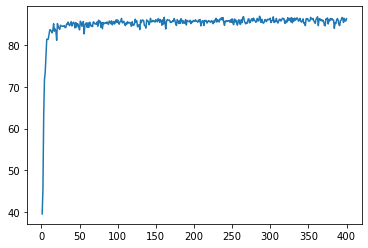

In [9]:
print("Model of: "+model_name +
      " running on: "+dataset_name+"\n")

print("Total Run {} epoch(s)".format(Grandstore['total_epoch_run']))

plt.plot(*[range(1,Grandstore['total_epoch_run']+1)],Grandstore['acclog'])
print("Accuracy MIN: {} / MAX: {}".format(Grandstore['minacc'],Grandstore['maxacc']))
print()
print("Top {} performing epochs:".format(TOP_ACCURACY_TRACK))


gstm=Grandstore['topmodels']
for i in range(TOP_ACCURACY_TRACK):
    easy=gstm[TOP_ACCURACY_TRACK-i-1]
    print("#{} epoch {}\t||train_acc {}%\t||test {}%".format(i+1,easy[2],easy[0],easy[1]))
print()
print("Last epoch:")
lsmd=Grandstore['lastmodel']
print("epoch {}\t||train_acc {}%\t||test {}%".format(Grandstore['total_epoch_run'],lsmd[0],lsmd[1]))
      
print()
print("The model has parameters: {}".format(get_n_params(model)))
#grandstore['lastmodel']=((training_accuracy,train_epoch,thisepochtestresult))
# grandstore['lastmodel']=(training_accuracy,thisepochtestresult,epoch+1,train_epoch)

In [15]:
  
f1=open(grandstore_string,"wb")
pickle.dump(Grandstore,f1)
f1.close()
# with open(grandstore_string, 'rb') as file:
#     myvar = pickle.load(file)
#     print(myvar)